# Working with XDF data using MNE
The goal of this notebook is to import data saved using the LSL Lab Recorder, and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [1]:
import mne
import matplotlib.pyplot as plt
import pyxdf
import numpy as np
import time
import librosa # optional, only needed to convert MIDI keys to notes

## Path to dataset

In [2]:
DATA_PATH = r'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001/'
DATA_PATH+= '/diverse/sub-matthias_ses-S001_task-Default_run-001_diverse.xdf'

In [3]:
# Read in the LSL streams from the XDF file
START_TIME = time.time()
streams, header = pyxdf.load_xdf(DATA_PATH) # this could take ~80 seconds..
print(f'Loaded in {time.time() - START_TIME} s')

Loaded in 84.05677795410156 s


In [4]:
streams[2]

{'info': defaultdict(list,
             {'name': ['glove_data'],
              'type': ['imu_data'],
              'channel_count': ['6'],
              'channel_format': ['float32'],
              'source_id': ['glove'],
              'nominal_srate': ['100.0000000000000'],
              'version': ['1.100000000000000'],
              'created_at': ['11176.05913058800'],
              'uid': ['1938a1eb-4baf-42a7-939c-009f8d03e75e'],
              'session_id': ['default'],
              'hostname': ['jobstNotebook'],
              'v4address': [None],
              'v4data_port': ['16572'],
              'v4service_port': ['16572'],
              'v6address': [None],
              'v6data_port': ['16573'],
              'v6service_port': ['16573'],
              'desc': [None],
              'stream_id': 1,
              'effective_srate': 99.99333404539185}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['17778.843508791'],
               'last_timestamp': 

## Check the duration of each recorded stream

In [5]:
for s in streams:
    name = s['info']['name']
    
    # the footer timestamps might be coming from different machines?
    first_timestamp = float(s['footer']['info']['first_timestamp'][0])
    last_timestamp = float(s['footer']['info']['last_timestamp'][0])
    print(name, first_timestamp, last_timestamp, last_timestamp -first_timestamp)
    
    # These seem more comparable
    print(s['time_stamps'][0])

['CGX Quick-32r Q32r-0524 Impedance'] 627325.377451 628142.3856054 817.0081543999258
627325.2739816022
['CGX Quick-32r Q32r-0524'] 627325.3774481 628142.3856052 817.0081570999464
627325.2739802459
['glove_data'] 17778.843508791 18595.921497388 817.0779885970005
627325.3522151901
['ev_ts'] 27212.626183671 28028.739800553 816.1136168820012
627326.3012936276
['MIDIStream'] 17813.922145359 18571.476104105 757.5539587460007
627360.4304148377
['MyAudioStream'] 627325.4127071757 628139.2895727557 813.8768655799795
627325.3077660879


In [6]:
# Get the first time stamp across all streams (read from time_stamps)
first_timestamps = []

for s in streams: # loop through remaining streams
    s_name = s['info']['name']
    t0 = s['time_stamps'][0]
    print(t0, '\t', s_name)
    
    first_timestamps.append(t0)
    
first_timestamp = min(first_timestamps)
print(first_timestamp, '\t', '<== earliest')   

627325.2739816022 	 ['CGX Quick-32r Q32r-0524 Impedance']
627325.2739802459 	 ['CGX Quick-32r Q32r-0524']
627325.3522151901 	 ['glove_data']
627326.3012936276 	 ['ev_ts']
627360.4304148377 	 ['MIDIStream']
627325.3077660879 	 ['MyAudioStream']
627325.2739802459 	 <== earliest


# Collect stream info and data

In [7]:
lsl_streams = {} # for collecting time stamps and data

# Identify EEG data and impedance streams separately to collect metadata (channel names, etc)
# Remaining streams are collected in one dict

for s in streams:
    s_name = s['info']['name'][0]
    s_type = s['info']['type'][0]
    print(f'Stream Name: {s_name}\tType: {s_type}')
    print('-'*50)
    
    # Get the EEG data stream for CGX
    if ('CGX' in s_name) and (s_type == 'EEG'):
        eeg_data = s['time_series']
        eeg_t = s['time_stamps'] - first_timestamp # offset first time stamp to t=0
        eeg_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_sfreq = s['info']['effective_srate']
        print(f'Channels: {eeg_ch_names}')
        print(f'Unit: {eeg_ch_units}')
        print(f'Eff. Sampling Rate: {eeg_sfreq} Hz')
        
    # Get the impedance data stream for CGX
    elif ('CGX' in s_name) and (s_type == 'Impeadance'): # typo in the stream name?
        z_data = s['time_series']
        z_t = s['time_stamps'] - first_timestamp
        z_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_sfreq = s['info']['effective_srate']
        print(f'Channels: {z_ch_names}')
        print(f'Unit: {z_ch_units}')
        print(f'Eff. Sampling Rate: {z_sfreq} Hz')
        
    # Misc streams
    else:
        lsl_streams[s_type] = {}
        lsl_streams[s_type]['data'] = s['time_series']
        lsl_streams[s_type]['time'] = s['time_stamps'] - first_timestamp
        print('shape:', lsl_streams[s_type]['data'].shape)
        
    print('='*50)

Stream Name: CGX Quick-32r Q32r-0524 Impedance	Type: Impeadance
--------------------------------------------------
Channels: ['AF7-Z', 'Fpz-Z', 'F7-Z', 'Fz-Z', 'T7-Z', 'FC6-Z', 'Fp1-Z', 'F4-Z', 'C4-Z', 'Oz-Z', 'CP6-Z', 'Cz-Z', 'PO8-Z', 'CP5-Z', 'O2-Z', 'O1-Z', 'P3-Z', 'P4-Z', 'P7-Z', 'P8-Z', 'Pz-Z', 'PO7-Z', 'T8-Z', 'C3-Z', 'Fp2-Z', 'F3-Z', 'F8-Z', 'FC5-Z', 'AF8-Z', 'A2-Z', 'ExG 1-Z', 'ExG 2-Z', 'ACC32-Z', 'ACC33-Z', 'ACC34-Z', 'Packet Counter-Z', 'TRIGGER-Z']
Unit: ['kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms']
Eff. Sampling Rate: 499.99535467080483 Hz
Stream Name: CGX Quick-32r Q32r-0524	Type: EEG
--------------------------------------------------
Channels: ['AF7', 'Fpz', 'F7', 'Fz', 'T7', 'FC6', 'Fp1'

In [8]:
print(sum(eeg_data[:, -1]>0)) # number of events in trigger channel
np.unique(eeg_data[:, -1]) # types of trigger events seen

152120


array([    0.,  8192., 16384., 24576.], dtype=float32)

Event | Description
:-- | --:
Audio Left | 8192
Audio Right | 16384
Audio Left+Right | 24576

(is the mic outputting stereo?)

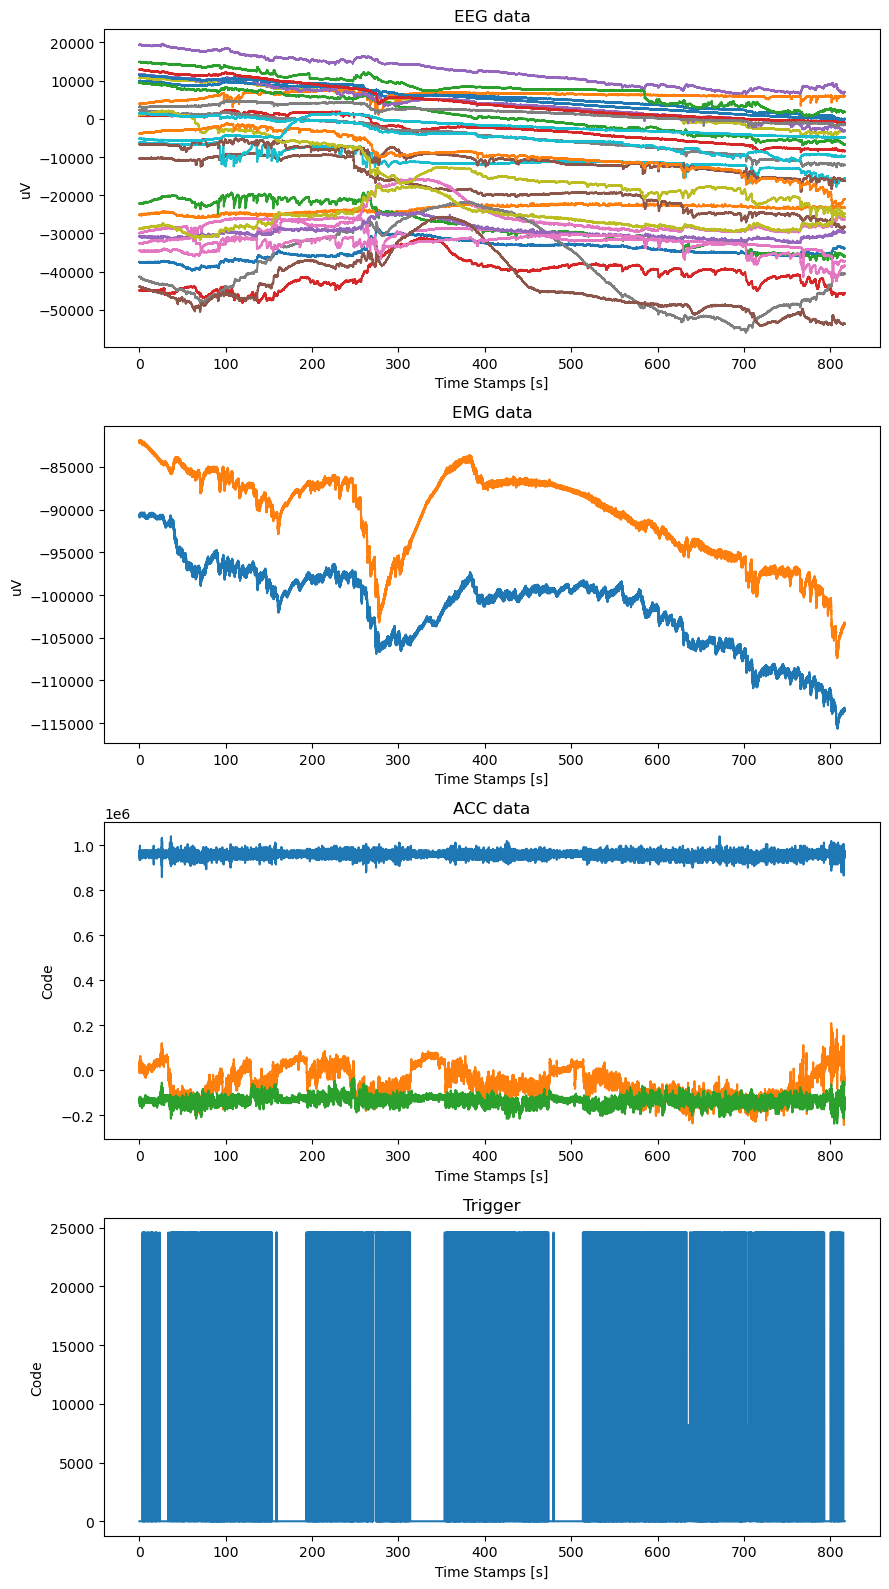

In [9]:
# Plot EEG data
fig, ax = plt.subplots(4, 1, figsize=(9, 16))

i = 0
ax[i].plot(eeg_t, eeg_data[:, :30])
ax[i].set_ylabel('uV')
ax[i].set_xlabel('Time Stamps [s]')
ax[i].set_title('EEG data')

i += 1
ax[i].plot(eeg_t, eeg_data[:, 30:32])
ax[i].set_ylabel('uV')
ax[i].set_xlabel('Time Stamps [s]')
ax[i].set_title('EMG data')

i += 1
ax[i].plot(eeg_t, eeg_data[:, 32:35])
ax[i].set_ylabel('Code')
ax[i].set_xlabel('Time Stamps [s]')
ax[i].set_title('ACC data')

# skip packet counter plot

i += 1
ax[i].plot(eeg_t, eeg_data[:, 36])
ax[i].set_ylabel('Code')
ax[i].set_xlabel('Time Stamps [s]')
ax[i].set_title('Trigger')

'''
# Plot event markers
for i in range(len(events)):
    event_t = events_t[i]
    event_v = events[i][0]
    event_type = events[i][1]
    
    if event_type == 'left':
        ax[0].axvline(x = event_t, c='pink')
    elif event_type == 'right':
        ax[0].axvline(x = event_t, c='c')
    elif event_type == 'enter':
        ax[0].axvline(x = event_t, c='r')
    
ax[1].plot(z_t, z_data)
ax[1].set_ylabel('kOhms')
ax[1].set_title('Impedance')

'''

plt.tight_layout()
plt.show()

# Prepare to import data to mne

## Rescale EEG data to V
(only run this once!)

In [10]:
print(eeg_data[:, 0])

# Rescale units of eeg_data to V
if 'microvolts' in eeg_ch_units:
    eeg_data[:, :32] /= 1e6 # only rescale EEG and ExG channels
    
print(eeg_data[:, 0])

[-37538.562 -37543.83  -37545.86  ... -33943.5   -33943.773 -33939.027]
[-0.03753856 -0.03754383 -0.03754586 ... -0.0339435  -0.03394377
 -0.03393903]


In [11]:
eeg_data.T.shape # mne expects (n_channels, n_times)

(37, 408409)

In [12]:
eeg_ch_names

['AF7',
 'Fpz',
 'F7',
 'Fz',
 'T7',
 'FC6',
 'Fp1',
 'F4',
 'C4',
 'Oz',
 'CP6',
 'Cz',
 'PO8',
 'CP5',
 'O2',
 'O1',
 'P3',
 'P4',
 'P7',
 'P8',
 'Pz',
 'PO7',
 'T8',
 'C3',
 'Fp2',
 'F3',
 'F8',
 'FC5',
 'AF8',
 'A2',
 'ExG 1',
 'ExG 2',
 'ACC32',
 'ACC33',
 'ACC34',
 'Packet Counter',
 'TRIGGER']

(Manually) Identify each channel's type for importing data to mne:

In [13]:
ch_types = []
ch_types.extend(['eeg']*30) # first 30 channels are EEG (including A2)
ch_types.extend(['misc']*(2+3+1)) # ExG x2, ACC x3, Packet Counter)
ch_types.extend(['stim']) # Trigger channel (probably unused)

Make an info object for importing data to mne:

https://mne.tools/stable/generated/mne.create_info.html

In [14]:
info = mne.create_info(
    ch_names = eeg_ch_names,
    sfreq = eeg_sfreq,
    ch_types = ch_types,
)

Import the data as a raw array:

https://mne.tools/stable/generated/mne.io.RawArray.html

In [15]:
raw = mne.io.RawArray(
    data = eeg_data.T, # mne expects (n_channels, n_times)
    info = info,
)

raw

Creating RawArray with float64 data, n_channels=37, n_times=408409
    Range : 0 ... 408408 =      0.000 ...   816.824 secs
Ready.


<RawArray | 37 x 408409 (816.8 s), ~115.3 MB, data loaded>

## Apply the 10-20 channel montage

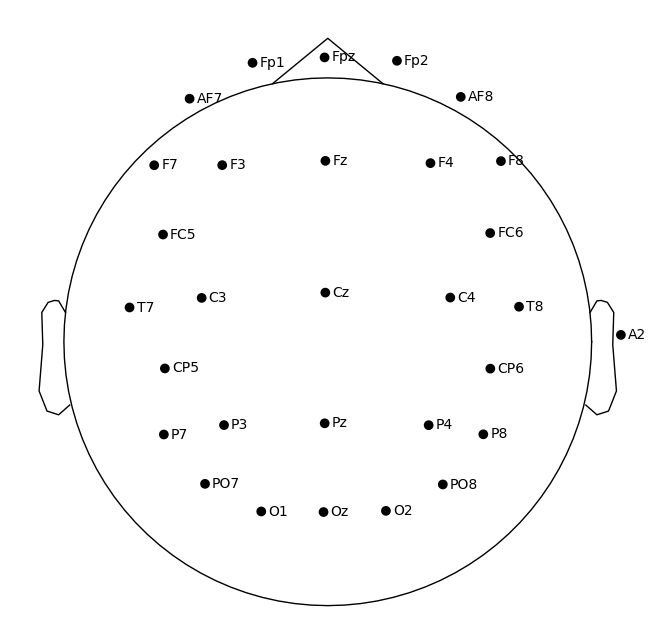

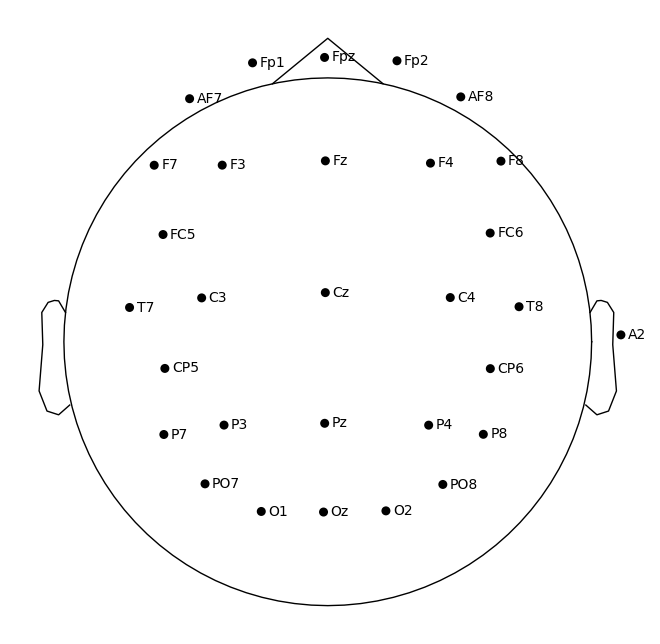

In [16]:
raw.info.set_montage('standard_1020', match_case=False)

# Plot the montage
mne.viz.plot_montage(raw.info.get_montage())

# Add annotations from MIDI stream

In [17]:
lsl_streams['MIDI']

{'data': array([[  0,  60, 113],
        [  0,  60,  64],
        [  0,  48, 116],
        ...,
        [  0,  50,  64],
        [  0,  60, 118],
        [  0,  60,  64]], dtype=int32),
 'time': array([ 35.15643459,  35.25257527,  36.38961551, ..., 791.66065554,
        792.62703634, 792.72558375])}

In [18]:
midi_q = {}
midi_events = []

for i, msg in enumerate(lsl_streams['MIDI']['data']):
    
    _ = msg[0] # could set this to be note_on or note_off events
    note = msg[1]
    velocity = msg[2]
    
    if not note in midi_q:
        on_t = lsl_streams['MIDI']['time'][i]
        midi_q[note] = {}
        midi_q[note]['onset'] = on_t
        midi_q[note]['velocity'] = velocity
        
    else: # note is already ON
        if velocity == 64: # OFF event
            off_t = lsl_streams['MIDI']['time'][i]
            midi_events.append(
                [
                    midi_q[note]['onset'], # start time
                    off_t - midi_q[note]['onset'], # duration
                    librosa.midi_to_note(note)
                ]
            )
            midi_q.pop(note, None) # remove note from the queue
            
midi_events = np.array(midi_events) # for easier indexing
midi_events

array([['35.156434591743164', '0.09614067478105426', 'C4'],
       ['36.389615506865084', '0.08385238435585052', 'C3'],
       ['37.14109707425814', '0.04357799876015633', 'F3'],
       ...,
       ['790.3323911777698', '0.08996831194963306', 'C3'],
       ['791.5999861869495', '0.06066935055423528', 'D3'],
       ['792.6270363408839', '0.09854740998707712', 'C4']], dtype='<U32')

In [19]:
# Total notes played
len(midi_events)/2 # halved as each key press would get an ON and OFF event

824.0

https://mne.tools/stable/auto_tutorials/raw/30_annotate_raw.html

In [20]:
lsl_annot = mne.Annotations(
    onset = midi_events[:, 0],
    duration = midi_events[:, 1], # setting durations to 0 to just label event onsets
    description = midi_events[:, 2]
)

raw.set_annotations(lsl_annot)

<RawArray | 37 x 408409 (816.8 s), ~115.3 MB, data loaded>

Using matplotlib as 2D backend.


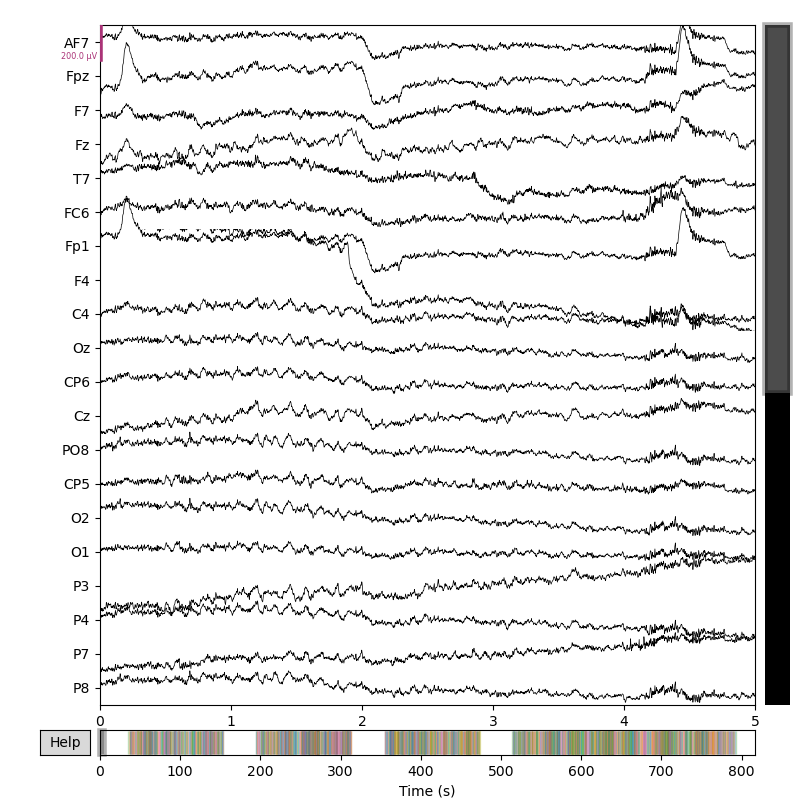

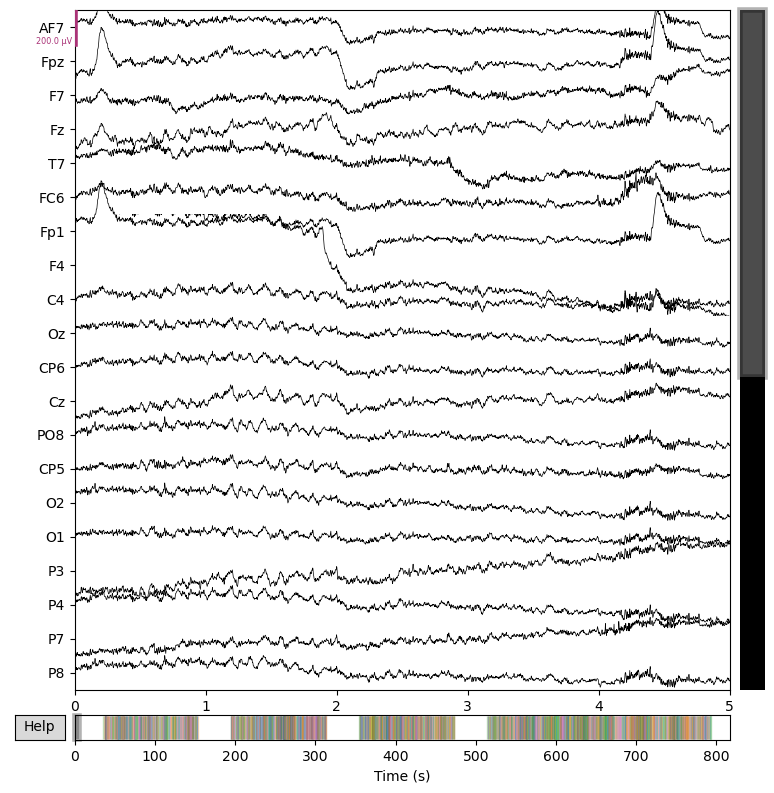

In [21]:
%matplotlib widget

# could go back to 
# %matplotlib inline 
# if the plot doubling becomes annoying

# using widget to make the plot interactive (for scrolling, bad channel selection, etc)

# scaling can help with visibility, especially if we have some bad channels / artifacts
scalings = {
    'eeg': 100e-6, 
    'eog': 500e-6,
    'misc': 100
} 

# In case you want to manually flag some channels as bad (could also click in the plot)
bad_chans = []
raw.info['bads'] = bad_chans

PLOT_WINDOW_START_s = 0
PLOT_WINDOW_DUR_s = 5

raw.plot(
    scalings = scalings,
    #butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

# Manually reject bad data segments
(skip for now)

In [22]:
if 0: 
    bad_annot = mne.Annotations(
        onset = [7, 11, ],
        duration = [3, 19, ], # setting durations to 0 to just label event onsets
        description = "bad",
    )

    #raw.set_annotations(raw.annotations + bad_annot)
    raw.set_annotations(lsl_annot + bad_annot)
    
    # Plot again
    raw.plot(
        scalings = scalings,
        butterfly = True,
        start = PLOT_WINDOW_START_s,
        duration = PLOT_WINDOW_DUR_s,
    )

In [23]:
# Remove any erroneous annotations (if needed)
# raw.annotations[5]
# raw.annotations.delete(5)

# Power Spectra
(before filtering)

Effective window size : 2.048 (s)


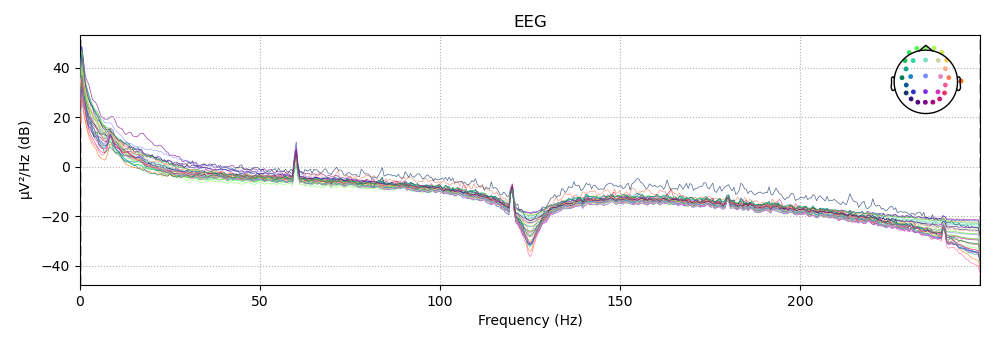

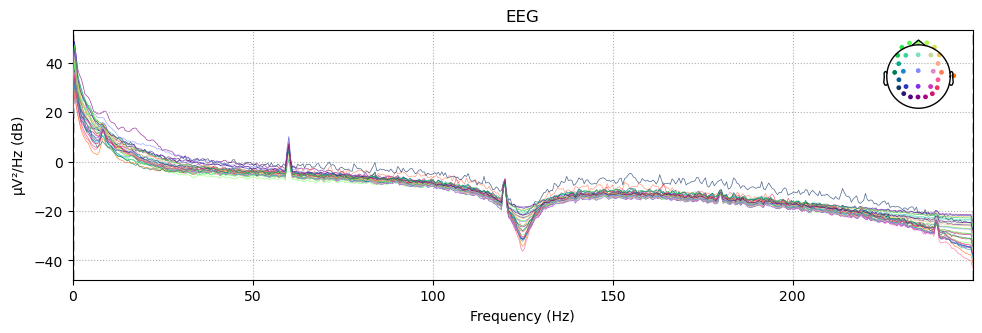

In [24]:
raw.compute_psd(n_fft = 1024).plot(average = False)

Let's bandpass filter the data:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


Effective window size : 2.048 (s)


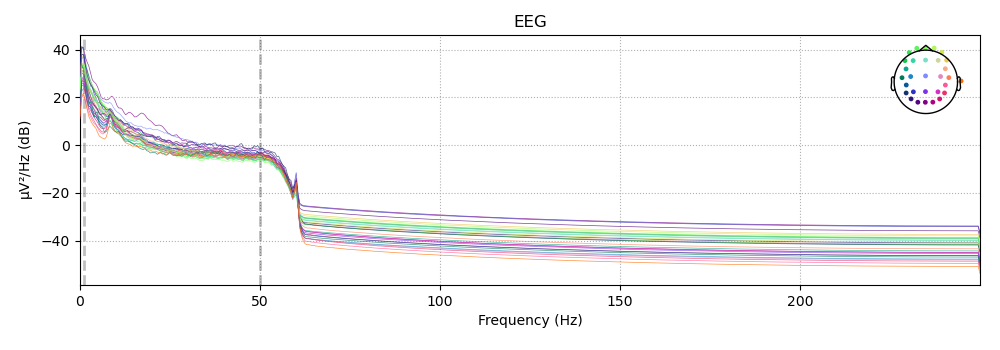

Effective window size : 2.048 (s)


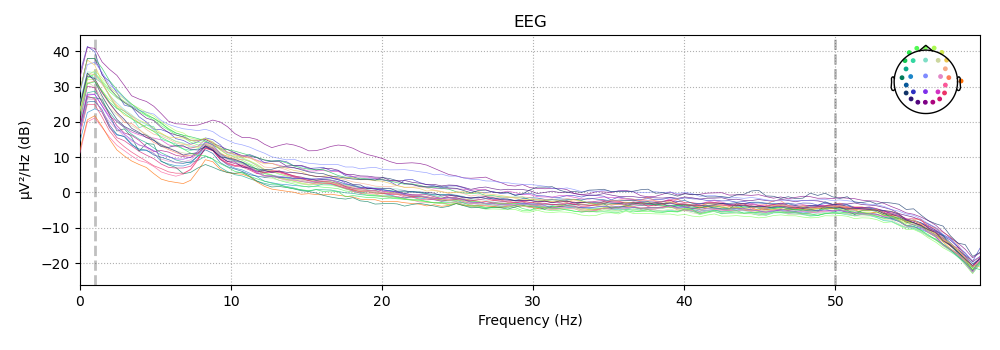

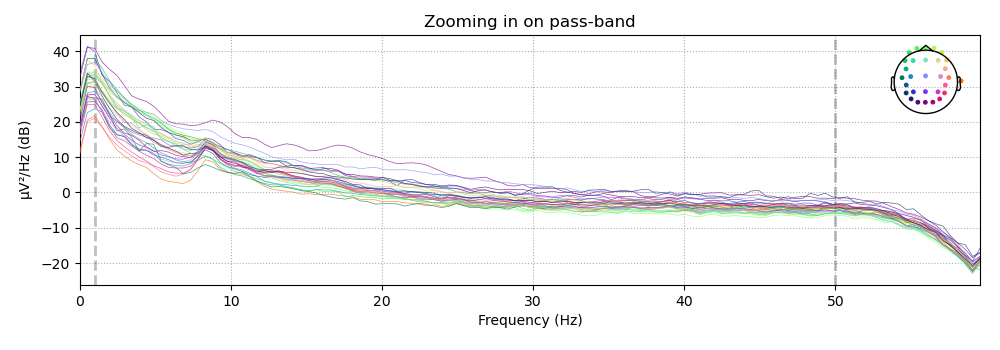

In [25]:
l_freq = 1
h_freq = 50

raw_filt = raw.copy().filter( # make a copy of the array to avoid modifying in place
    l_freq = l_freq, # lower cut-off, in Hz
    h_freq = h_freq, # upper cut-off, in Hz
)

# And look at the PSD again
raw_filt.compute_psd(n_fft = 1024).plot(average = False)

n_fft = 1024

# picks = [''] # a list of channels that you want to focus on, if any
fig = raw_filt.compute_psd(
    # picks= picks,
    fmin = 0, # lower limit to plot
    fmax = 60, # upper limit to plot
    # tmin = 0, # if only using a subset of the data for PSD computation
    # tmax = 10,
    n_fft = n_fft,
).plot()

# Some reformatting if needed
# fig.get_axes()[0].set_ylim(YLIM_MIN, YLIM_MAX)
fig.get_axes()[0].set_title('Zooming in on pass-band')
plt.show()

# Identify any bad channels

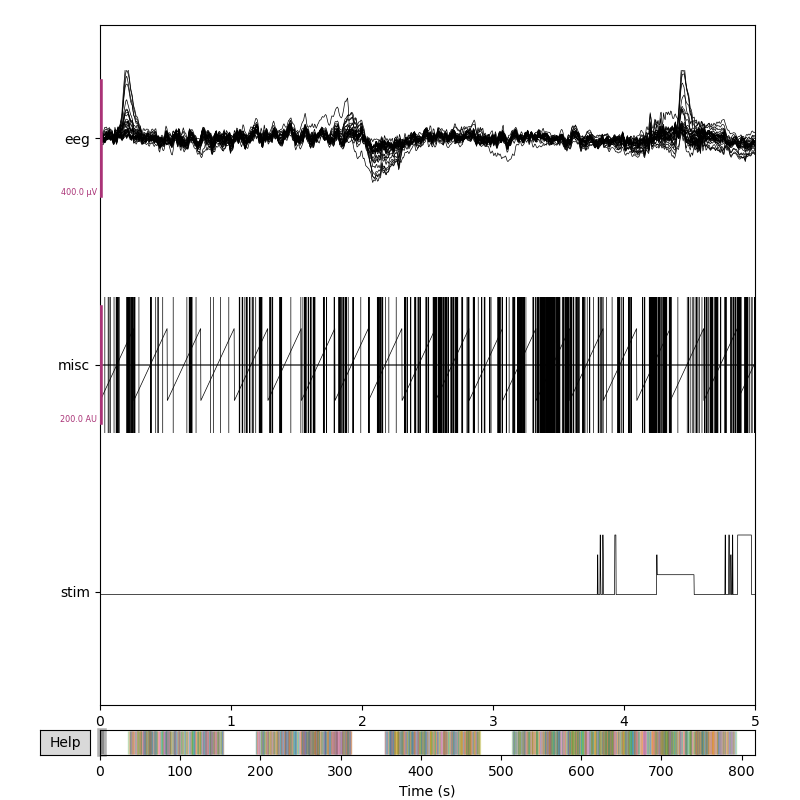

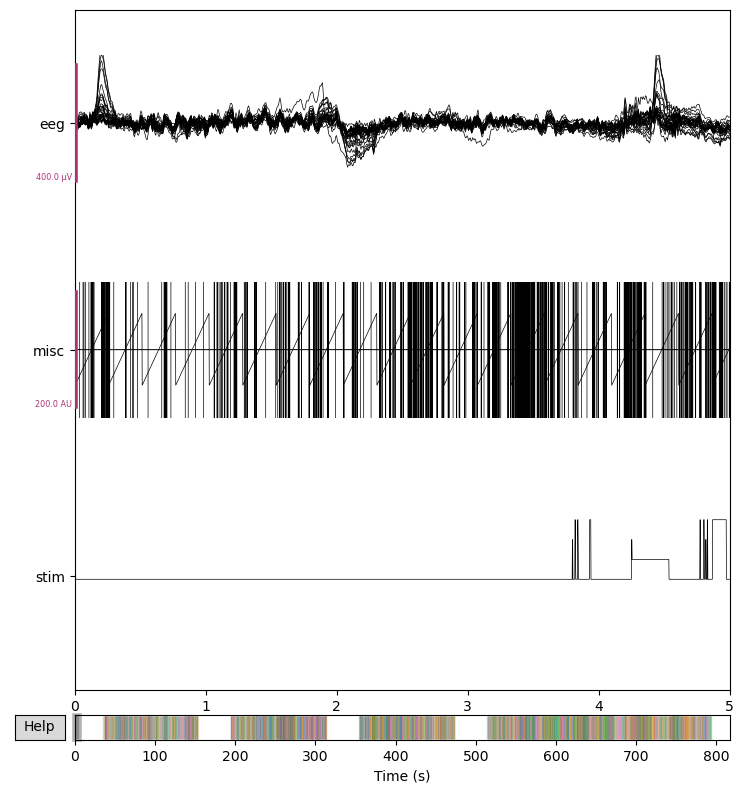

In [26]:
## Update scalings if needed
scalings['eeg'] = 200e-6 
# scalings['eog'] = 500e-6
# scalings['misc'] = 100

raw_filt.info.bads = ['Oz'] #, 'PO8', 'Fp2', 'F7', 'P3'] # ideally could label bad segments instead of dropping channels

# Drop bad channels from visual examination before running ICA
raw_filt_drop_bad = raw_filt.copy().drop_channels(raw_filt.info.bads)

raw_filt_drop_bad.plot(
    scalings = scalings,
    butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

## Re-reference to average? Skip for now.
https://mne.tools/stable/generated/mne.set_eeg_reference.html

Re-referencing to average seems to just output noise...

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


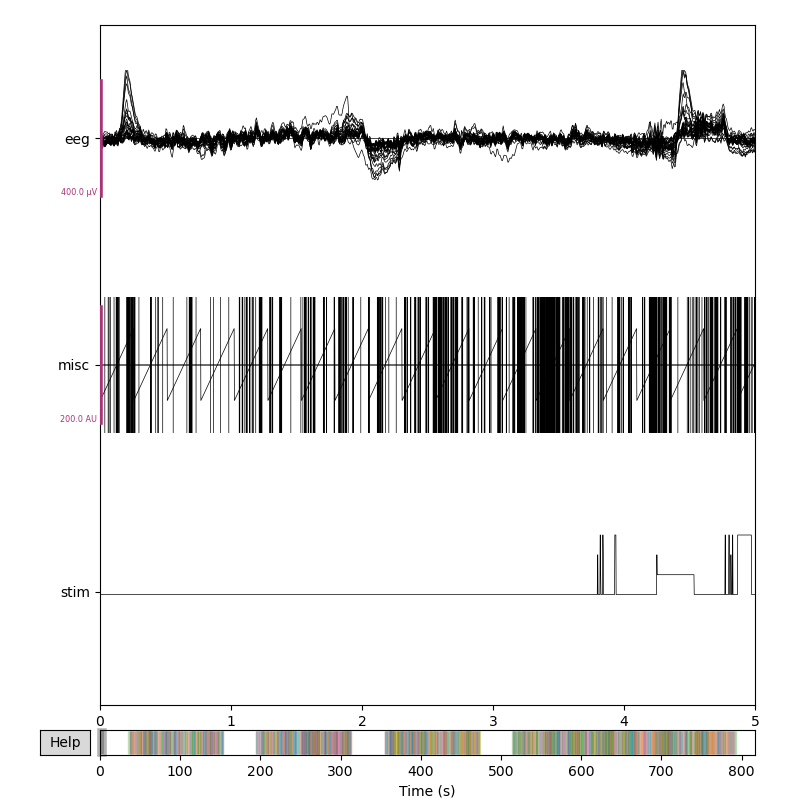

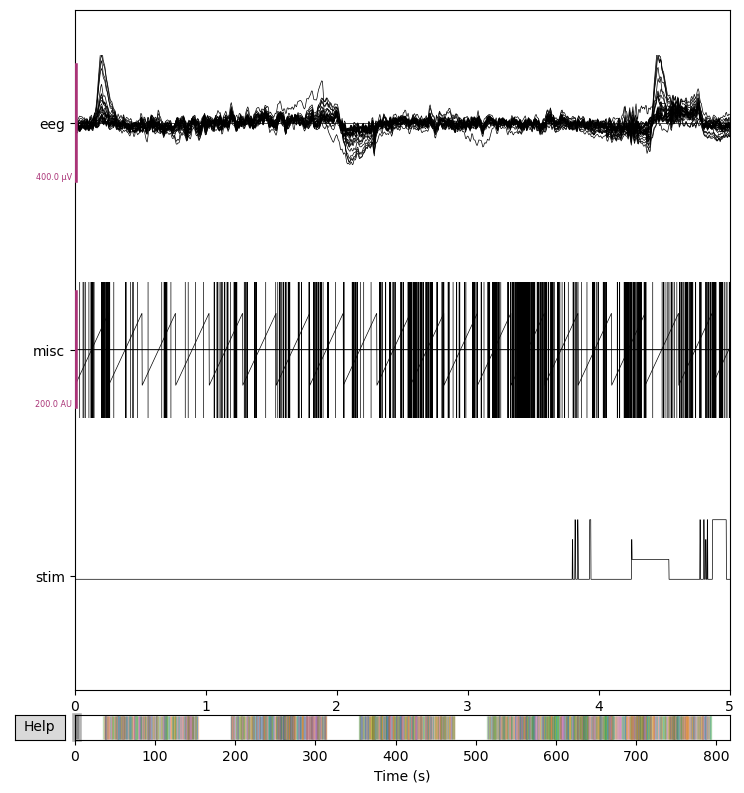

In [27]:
raw_filt_drop_bad_rref, _ = mne.set_eeg_reference(
    raw_filt_drop_bad, 
    ref_channels=['A2'], # 'average'
)

raw_filt_drop_bad_rref.plot(
    scalings=scalings,
    butterfly=True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

# Lets find events from annotations

In [28]:
events, event_id = mne.events_from_annotations(raw_filt_drop_bad_rref)

Used Annotations descriptions: ['A2', 'A3', 'A4', 'A♯2', 'A♯3', 'A♯4', 'B2', 'B3', 'B4', 'B5', 'C3', 'C4', 'C5', 'C6', 'C♯3', 'C♯4', 'C♯5', 'D2', 'D3', 'D4', 'D5', 'D♯3', 'D♯4', 'D♯5', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'F5', 'F♯2', 'F♯3', 'F♯4', 'G2', 'G3', 'G4', 'G5', 'G♯2', 'G♯3', 'G♯4', 'G♯5']


In [29]:
events

array([[ 17578,      0,     12],
       [ 18195,      0,     11],
       [ 18559,      0,     37],
       ...,
       [395163,      0,     11],
       [395796,      0,     19],
       [396310,      0,     12]])

In [30]:
event_id

{'A2': 1,
 'A3': 2,
 'A4': 3,
 'A♯2': 4,
 'A♯3': 5,
 'A♯4': 6,
 'B2': 7,
 'B3': 8,
 'B4': 9,
 'B5': 10,
 'C3': 11,
 'C4': 12,
 'C5': 13,
 'C6': 14,
 'C♯3': 15,
 'C♯4': 16,
 'C♯5': 17,
 'D2': 18,
 'D3': 19,
 'D4': 20,
 'D5': 21,
 'D♯3': 22,
 'D♯4': 23,
 'D♯5': 24,
 'E2': 25,
 'E3': 26,
 'E4': 27,
 'E5': 28,
 'F2': 29,
 'F3': 30,
 'F4': 31,
 'F5': 32,
 'F♯2': 33,
 'F♯3': 34,
 'F♯4': 35,
 'G2': 36,
 'G3': 37,
 'G4': 38,
 'G5': 39,
 'G♯2': 40,
 'G♯3': 41,
 'G♯4': 42,
 'G♯5': 43}

In [31]:
_, counts = np.unique(events[:, 2], return_counts=True)
counts

array([  4,  21,  35,   4,  45,  44,  11,  50,  44,   2,  76, 142,  60,
         2,  26,  31,  13,   1,  51,  86,  29,  45,  93,  20,   2,  26,
        41,  10,   1,  63,  82,  13,   3,  23,  41,  11, 111, 109,   9,
         9,  76,  78,   5])

In [32]:
NUM_ERP = 5 # number of notes to make ERPs from
ERP_NOTES = [x for x in np.argsort(-counts)[:NUM_ERP]] # sort descending, get top 5 played notes

erp_event_id = []
for note in ERP_NOTES:
    for key in event_id:
        if event_id[key] == note:
            print(key, note, counts[note])
            erp_event_id.append(key)
            
erp_event_id

C3 11 142
G2 36 111
G3 37 109
D♯3 22 93
D3 19 86


['C3', 'G2', 'G3', 'D♯3', 'D3']

# Export dataset to EEGLAB

In [33]:
# uncomment to install eeglabio
# !pip3 install eeglabio

In [34]:
MAT_PATH = DATA_PATH.split('.xdf')[0] + f'_bpf_{l_freq}-{h_freq}Hz' + '.mat'
MAT_PATH

'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001//diverse/sub-matthias_ses-S001_task-Default_run-001_diverse_bpf_1-50Hz.mat'

In [35]:
# This is a .set file that can be loaded directly into MATLAB (using load)
## Note that this would include any 'bad' channels identified above

try:
    mne.export.export_raw(
        MAT_PATH, 
        raw_filt_drop_bad_rref, 
        fmt='eeglab')
except FileExistsError as e:
    print(e)

# if exporting to EDF:
# Note that the BrainVision format specification supports only µV.
#raw_filt_drop_bad = raw_filt.copy().drop_channels(raw_filt.info['bads'])
#mne.export.export_raw('head_bob-raw_filt-drop_bad_chan.edf', raw_filt_drop_bad, fmt='edf')

Destination file exists. Please use option "overwrite=True" to force overwriting.


# Epoching for ERPs

In [36]:
eps = mne.Epochs(
    # raw_filt,
    # raw_filt_drop_bad, 
    raw_filt_drop_bad_rref,
    events = events, 
    event_id = event_id, 
    tmin=-0.5,
    tmax=1.5,
    baseline=None,
    event_repeated = 'drop',
)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1618 matching events found
No baseline correction applied
0 projection items activated


C3
Using data from preloaded Raw for 73 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


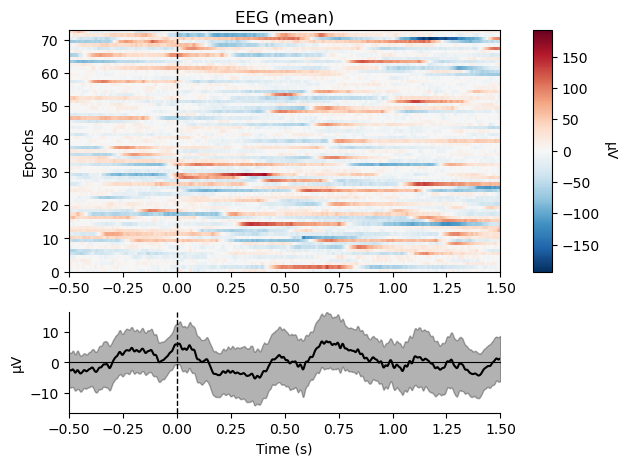

G2
Using data from preloaded Raw for 11 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


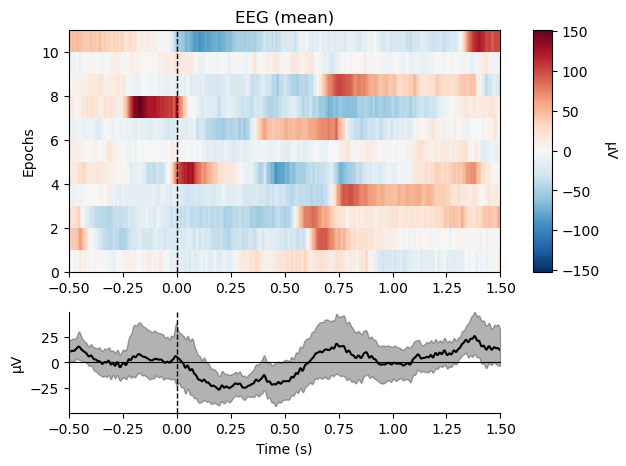

G3
Using data from preloaded Raw for 110 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


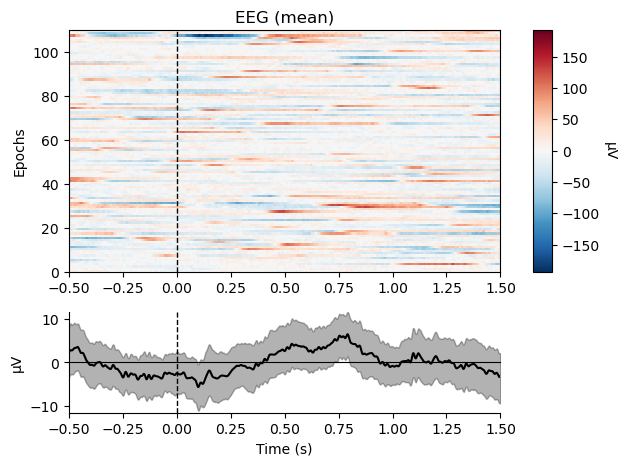

D♯3
Using data from preloaded Raw for 44 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
44 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


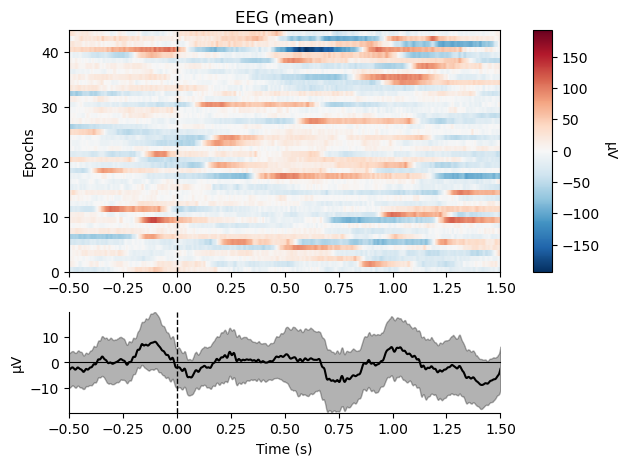

D3
Using data from preloaded Raw for 51 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
51 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


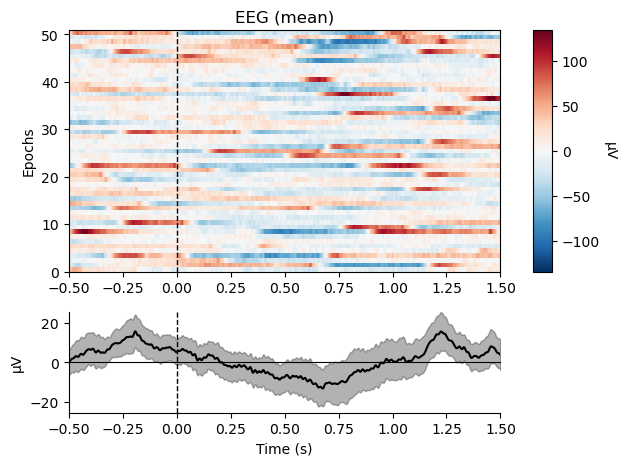

In [37]:
%matplotlib inline

for ev_id in erp_event_id:
    print(ev_id)
    eps[ev_id].plot_image(
        #picks = [],
        combine='mean'
    )

C3
No projector specified for this dataset. Please consider the method self.add_proj.


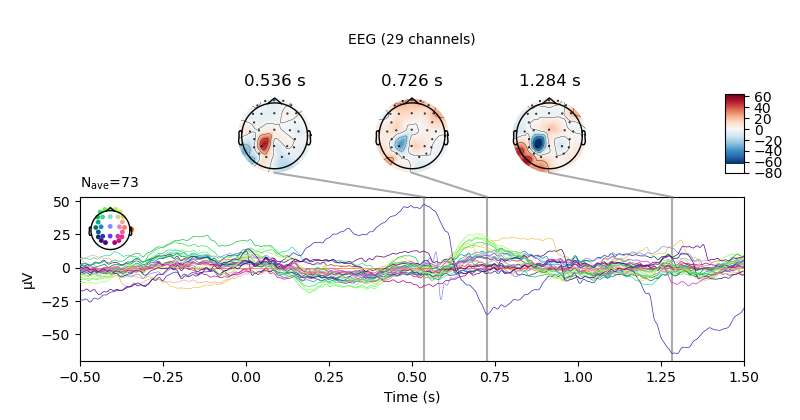

G2
No projector specified for this dataset. Please consider the method self.add_proj.


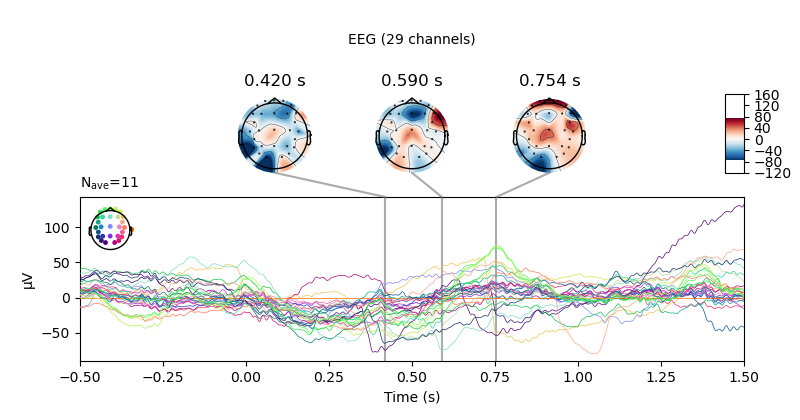

G3
No projector specified for this dataset. Please consider the method self.add_proj.


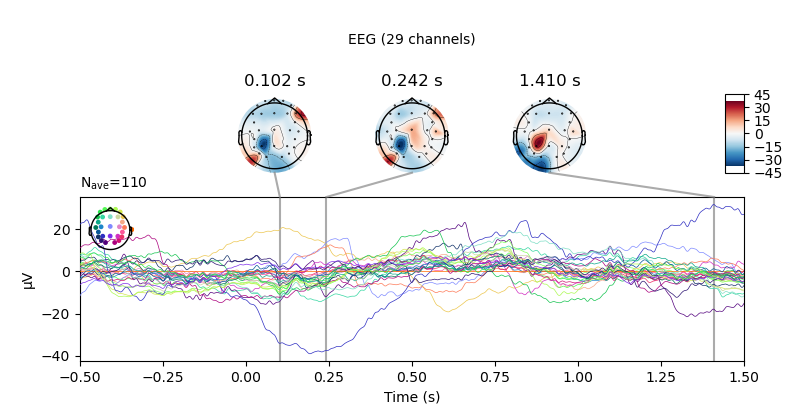

D♯3
No projector specified for this dataset. Please consider the method self.add_proj.


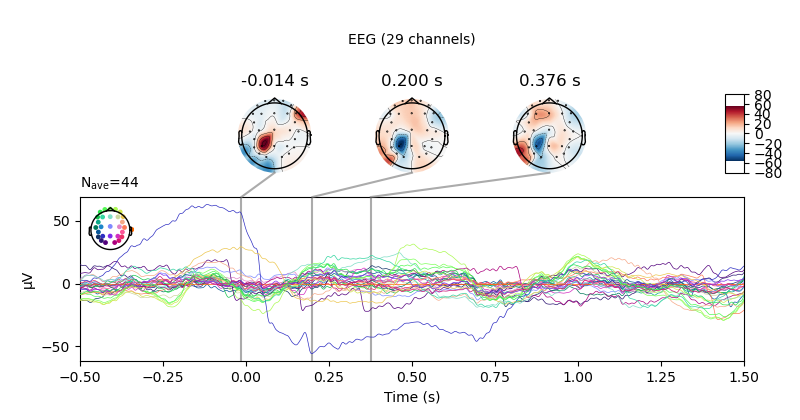

D3
No projector specified for this dataset. Please consider the method self.add_proj.


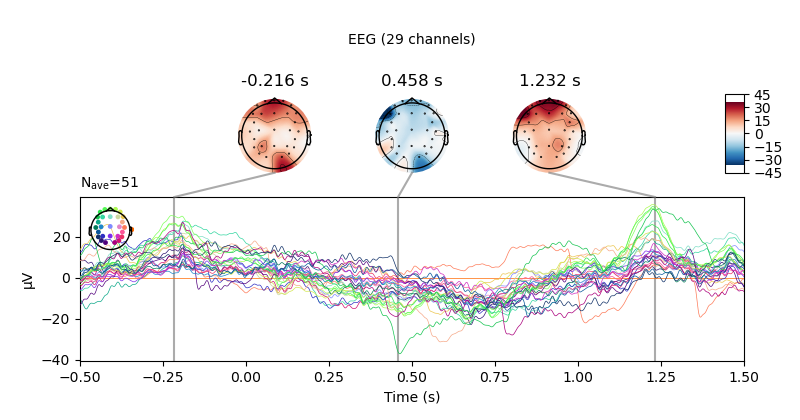

In [38]:
%matplotlib widget

for ev_id in erp_event_id:
    print(ev_id)
    eps[ev_id].average(
        # picks = []
    ).plot_joint()

# Import ASR'd data

In [39]:
from scipy.io import loadmat

In [40]:
after_asr = loadmat('/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001/diverse/after_asr.mat')

In [41]:
clean_data = after_asr['clean_data']
n_chans, n_samples = clean_data.shape

In [57]:
clean_data

array([[ 10.478824 ,  10.438895 ,  10.553011 , ...,   3.461771 ,
          9.912134 ,  15.733004 ],
       [-10.836592 , -10.6897745, -10.771467 , ...,   5.820386 ,
         11.944135 ,  16.803572 ],
       [ 10.33934  ,  11.971282 ,  13.710366 , ...,   4.997251 ,
         10.37236  ,  14.533548 ],
       ...,
       [ -9.551377 ,  -8.284052 ,  -7.4288054, ...,   4.7852645,
         10.697708 ,  13.809255 ],
       [  8.835816 ,  10.28198  ,  12.576855 , ...,   6.6328144,
         13.485182 ,  18.682041 ],
       [-25.588825 , -25.267677 , -25.186148 , ...,   9.909579 ,
         17.158257 ,  21.362637 ]], dtype=float32)

In [42]:
t_clean_data = after_asr['t_clean_data'][0]
t_clean_data.shape

(346649,)

In [101]:
n_clean_data = np.int64(t_clean_data * 500)
n_clean_data

array([     0,      1,      2, ..., 408409, 408410, 408411])

In [107]:
clean_data_full = np.zeros(
    shape=(n_chans, n_clean_data[-1])
)
clean_data_full.shape

(27, 408411)

In [109]:
clean_data_full[0, n_clean_data-1]

array([0., 0., 0., ..., 0., 0., 0.])

In [110]:
clean_data[0].shape

(346649,)

In [111]:
for ch in range(n_chans):
    clean_data_full[ch][n_clean_data -1] = clean_data[ch]
    
clean_data_full

array([[ 10.43889523,  10.55301094,  10.99168587, ...,   3.46177101,
          9.91213417,  15.73300362],
       [-10.68977451, -10.77146721, -11.03510094, ...,   5.82038593,
         11.94413471,  16.8035717 ],
       [ 11.97128201,  13.71036625,  15.41244316, ...,   4.99725103,
         10.37236023,  14.53354836],
       ...,
       [ -8.2840519 ,  -7.42880535,  -7.30749655, ...,   4.78526449,
         10.69770813,  13.80925465],
       [ 10.28197956,  12.57685471,  15.4508009 , ...,   6.63281441,
         13.48518181,  18.68204117],
       [-25.26767731, -25.18614769, -25.52174377, ...,   9.90957928,
         17.15825653,  21.36263657]])

In [112]:
clean_ch_names = eeg_ch_names[:16] + eeg_ch_names[16:n_chans]
len(clean_ch_names)

27

In [113]:
info = mne.create_info(
    ch_names = clean_ch_names,
    sfreq = 500,
    ch_types = ['eeg'] * n_chans,
)

In [114]:
raw_asr = mne.io.RawArray(
    clean_data_full / 1e6,
    info = info,
)
raw_asr

Creating RawArray with float64 data, n_channels=27, n_times=408411
    Range : 0 ... 408410 =      0.000 ...   816.820 secs
Ready.


<RawArray | 27 x 408411 (816.8 s), ~84.2 MB, data loaded>

In [115]:
raw_asr[0]

(array([[1.04388952e-05, 1.05530109e-05, 1.09916859e-05, ...,
         3.46177101e-06, 9.91213417e-06, 1.57330036e-05]]),
 array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 8.16816e+02,
        8.16818e+02, 8.16820e+02]))

In [116]:
raw_asr.info.set_montage('standard_1020', match_case=False)

<Info | 8 non-empty values
 bads: []
 ch_names: AF7, Fpz, F7, Fz, T7, FC6, Fp1, F4, C4, Oz, CP6, Cz, PO8, CP5, ...
 chs: 27 EEG
 custom_ref_applied: False
 dig: 30 items (3 Cardinal, 27 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 27
 projs: []
 sfreq: 500.0 Hz
>

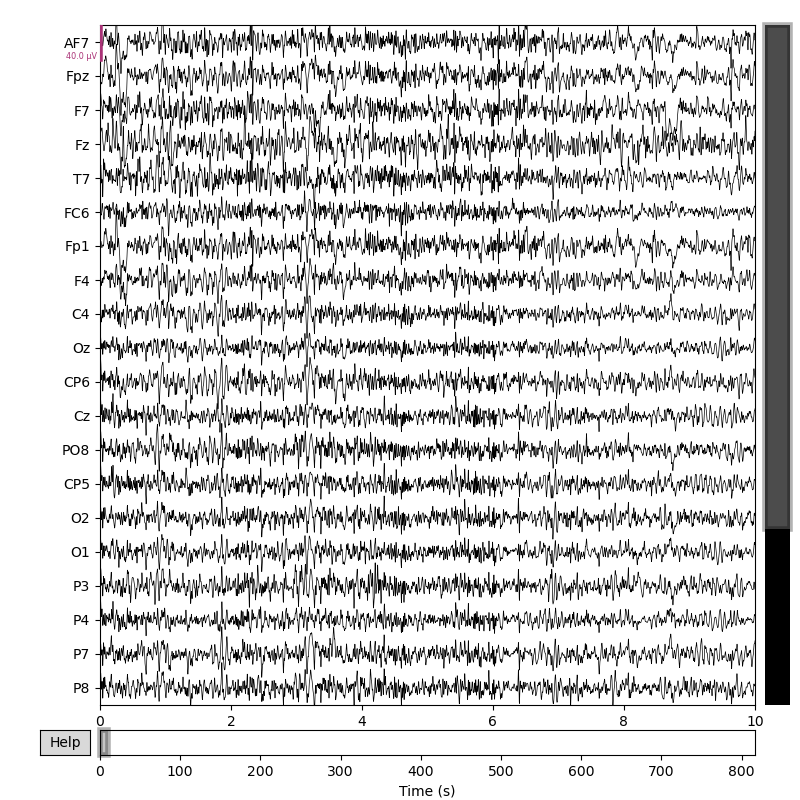

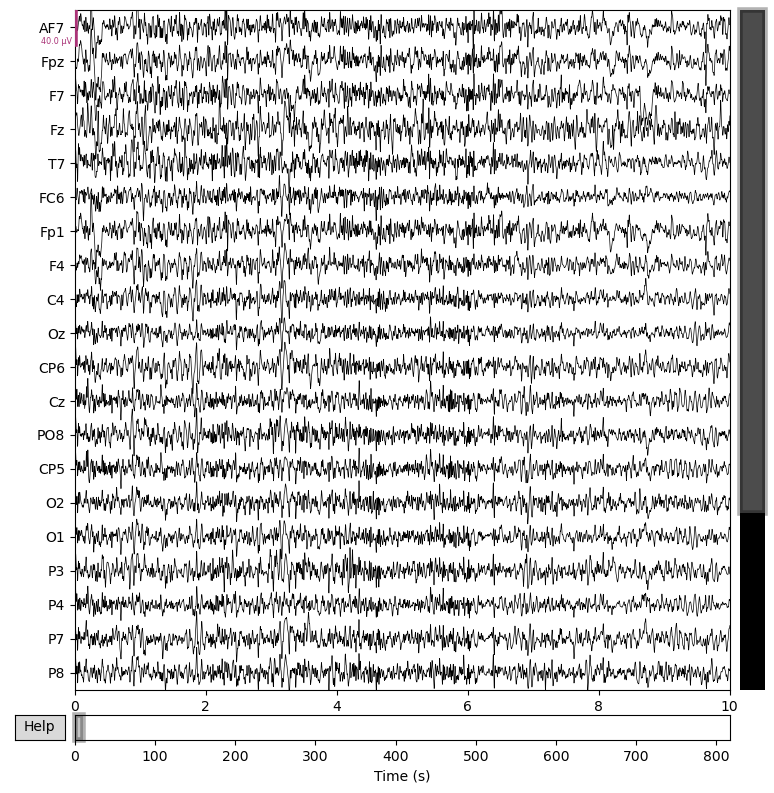

In [117]:
%matplotlib widget

raw_asr.plot()

In [118]:
eps_asr = mne.Epochs(
    raw_asr,
    events = events, 
    event_id = event_id, 
    tmin=-0.5,
    tmax=1.5,
    baseline=None,
    event_repeated = 'drop',
)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1618 matching events found
No baseline correction applied
0 projection items activated


C3
No projector specified for this dataset. Please consider the method self.add_proj.


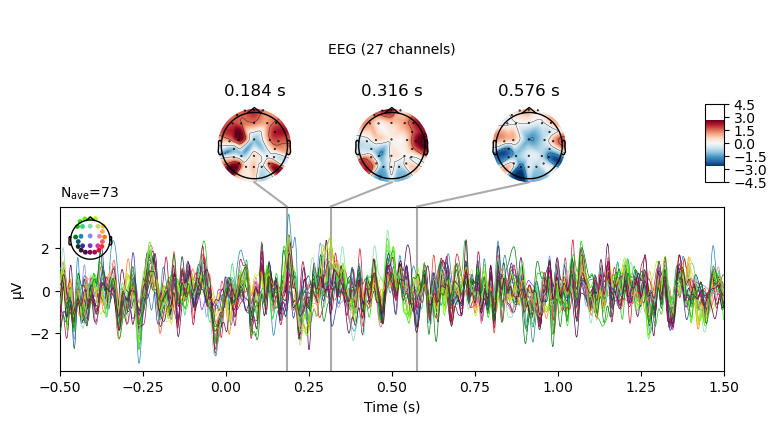

G2
No projector specified for this dataset. Please consider the method self.add_proj.


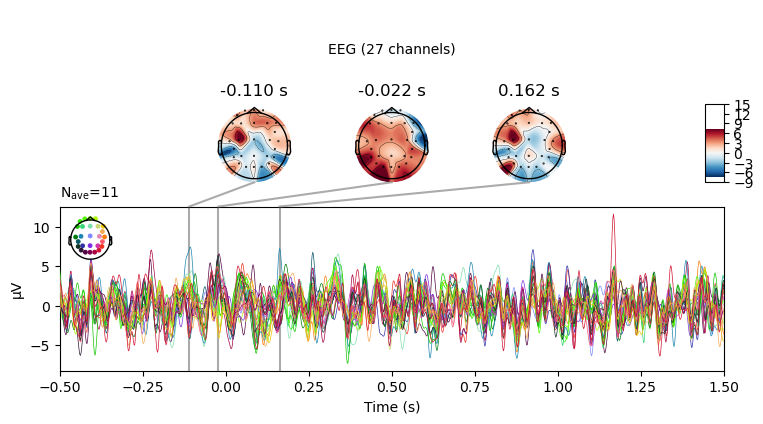

G3
No projector specified for this dataset. Please consider the method self.add_proj.


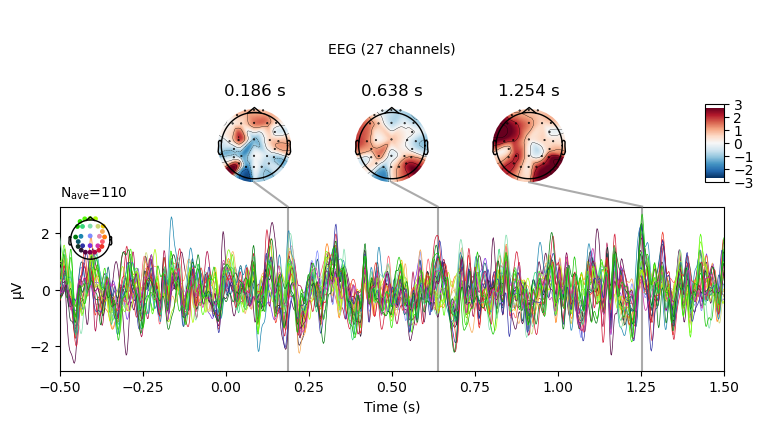

D♯3
No projector specified for this dataset. Please consider the method self.add_proj.


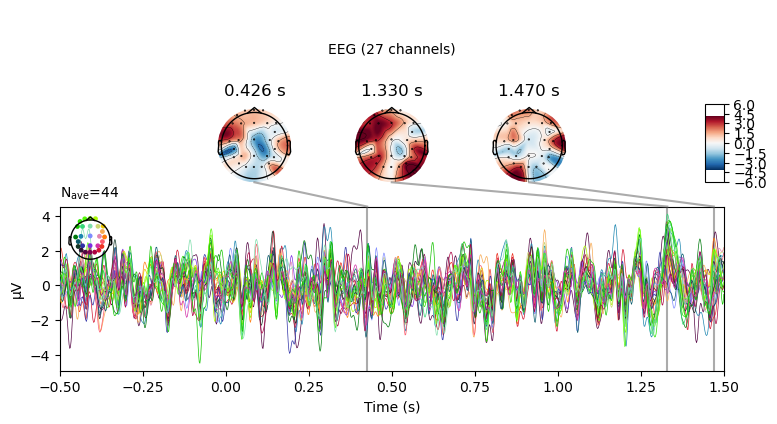

D3
No projector specified for this dataset. Please consider the method self.add_proj.


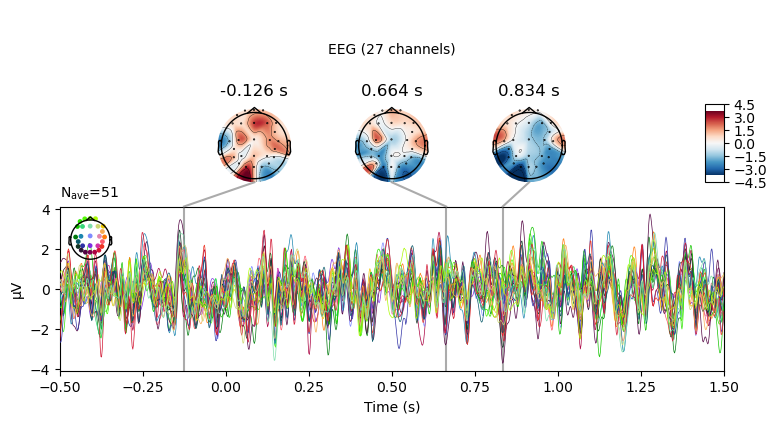

In [120]:
for ev_id in erp_event_id:
    print(ev_id)
    
    eps_asr[ev_id].average(
        #picks = ['Cz']
    ).plot_joint(
        #times = [-1.78, -1.38, 0.352, 0.65] #"peaks"
    )

C3
Using data from preloaded Raw for 73 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


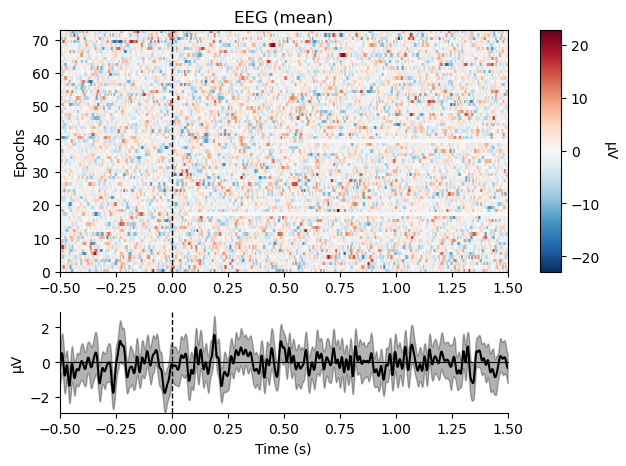

G2
Using data from preloaded Raw for 11 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


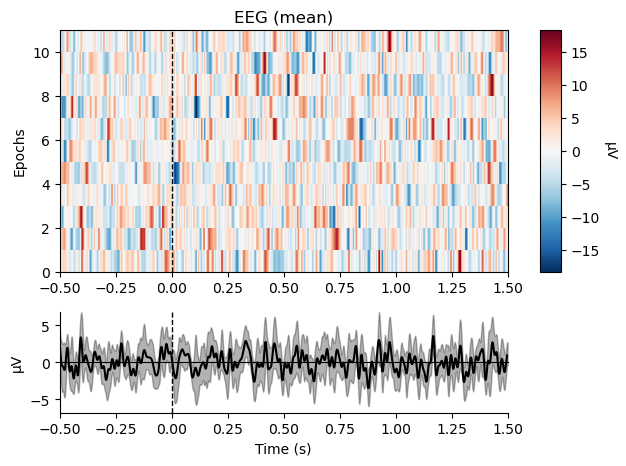

G3
Using data from preloaded Raw for 110 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


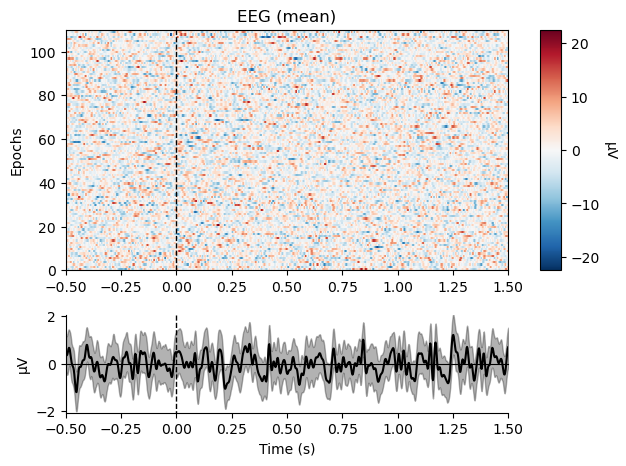

D♯3
Using data from preloaded Raw for 44 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
44 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


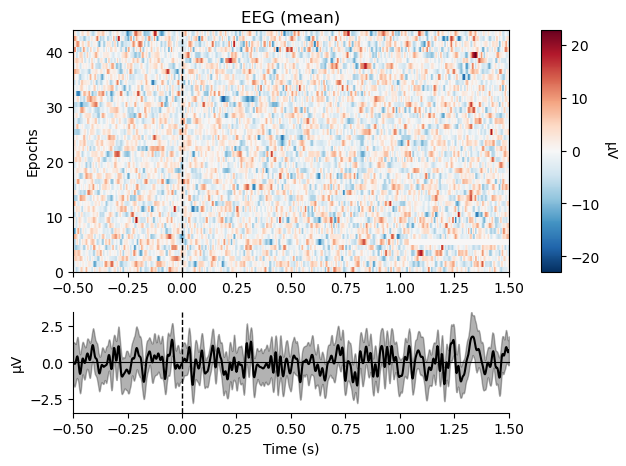

D3
Using data from preloaded Raw for 51 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
51 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


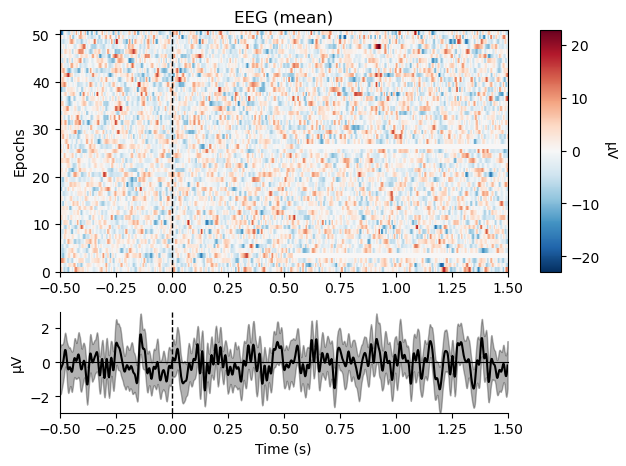

In [119]:
%matplotlib inline

for ev_id in erp_event_id:
    print(ev_id)
    eps_asr[ev_id].plot_image(
        #picks = [],
        combine='mean'
    )